# Chapter 3 - predicting house prices: a regression example

In [1]:
# Importing PlaidML. Make sure you follow this order
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
from keras.datasets import boston_housing
from keras import models, layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import timeit

import matplotlib.pyplot as plt

## Loading dataset

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

## Preparing data

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Model definition

In [5]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=['mae']
    )

    return model

## K-fold validation

In [6]:
k = 4
num_val_saples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_saples: (i + 1) * num_val_saples]
    val_targets = train_targets[i * num_val_saples: (i + 1) * num_val_saples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_saples],
        train_data[(i + 1) * num_val_saples:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_saples],
        train_targets[(i + 1) * num_val_saples:]],
        axis=0
    )

    model = build_model()
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0
    )
    val_mse, val_mae = model.evaluate(
        val_data,
        val_targets,
        verbose=0
    )
    all_scores.append(val_mae)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

## Plotting the training and validation loss

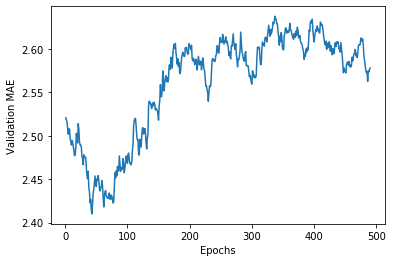

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


## Retraining model from scratch

In [10]:
model = build_model()

model.fit(
    train_data, 
    train_targets, 
    epochs=80, 
    batch_size=16, 
    verbose=0
)
test_mse_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [12]:
test_mse_score

[18.562270519780178, 2.6198509534200034]